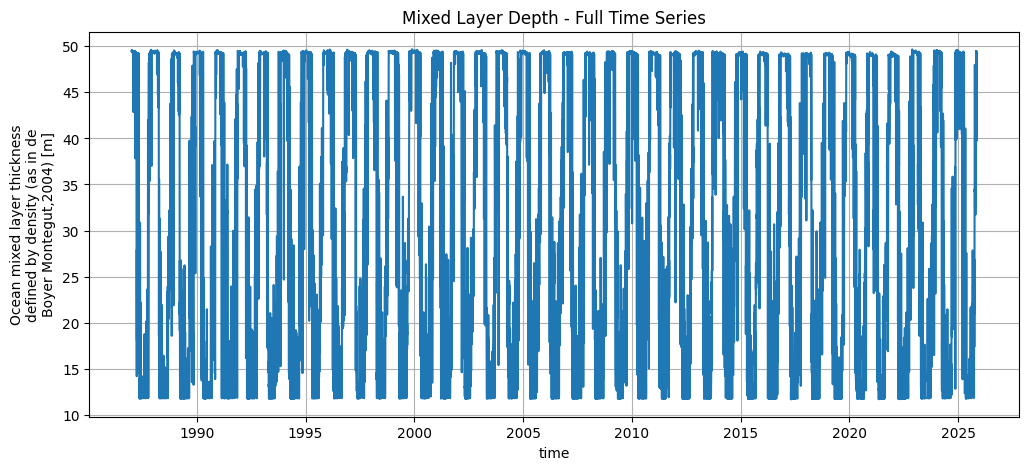

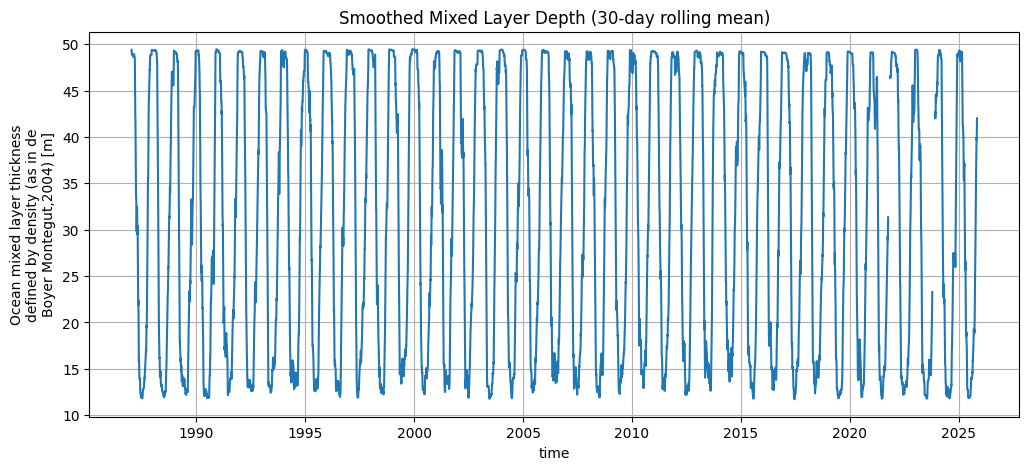

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

path = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\MIXED_LAYER_DEPTH\*.nc"

# Ανοίγουμε όλα τα αρχεία αλλά λέμε "load everything into RAM"
ds = xr.open_mfdataset(path, combine='by_coords', chunks={"time": -1}).load()

var = ds["mlotst"]

# Plot original time series
plt.figure(figsize=(12,5))
var.plot()
plt.title("Mixed Layer Depth - Full Time Series")
plt.grid(True)
plt.show()

# Rolling 30-day mean
smooth = var.rolling(time=30, center=True).mean()

plt.figure(figsize=(12,5))
smooth.plot()
plt.title("Smoothed Mixed Layer Depth (30-day rolling mean)")
plt.grid(True)
plt.show()

In [2]:
import xarray as xr
import matplotlib.pyplot as plt

path = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\OCEAN_TEMPERATURE\*.nc"

ds = xr.open_mfdataset(path, combine='by_coords')

print("Variables:", list(ds.data_vars))
print("Dataset loaded successfully!")

Variables: ['thetao']
Dataset loaded successfully!


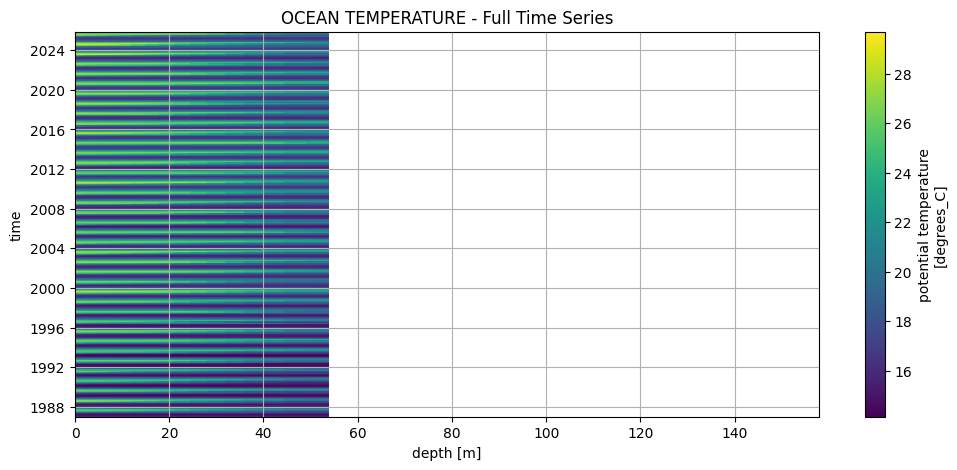

In [4]:
import xarray as xr
import matplotlib.pyplot as plt

path = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\OCEAN_TEMPERATURE\*.nc"

# Ανοίγουμε όλα τα αρχεία αλλά λέμε "load everything into RAM"
ds = xr.open_mfdataset(path, combine='by_coords', chunks={"time": -1}).load()

var = ds["thetao"]

# Plot original time series
plt.figure(figsize=(12,5))
var.plot()
plt.title("OCEAN TEMPERATURE - Full Time Series")
plt.grid(True)
plt.show()

Loading datasets...
Datasets merged successfully.
<xarray.Dataset> Size: 2MB
Dimensions:  (time: 14187, depth: 31)
Coordinates:
  * time     (time) datetime64[ns] 113kB 1987-01-01 1987-01-02 ... 2025-11-13
  * depth    (depth) float32 124B 1.018 3.166 5.465 7.92 ... 136.0 144.5 153.4
Data variables:
    mlotst   (time) float32 57kB 49.45 49.46 49.52 49.56 ... 45.86 49.42 49.35
    thetao   (time, depth) float32 2MB 16.07 16.07 16.07 16.07 ... nan nan nan
Attributes: (12/15)
    CDI:                       Climate Data Interface version 2.0.4 (https://...
    Conventions:               CF-1.0
    source:                    MFS E3R1
    institution:               Centro Euro-Mediterraneo sui Cambiamenti Clima...
    bulletin_date:             20200901
    bulletin_type:             reanalysis
    ...                        ...
    references:                Please check in CMEMS catalogue the INFO secti...
    title:                     Mixed Layer Depth (2D) - Daily Mean
    copernicusma

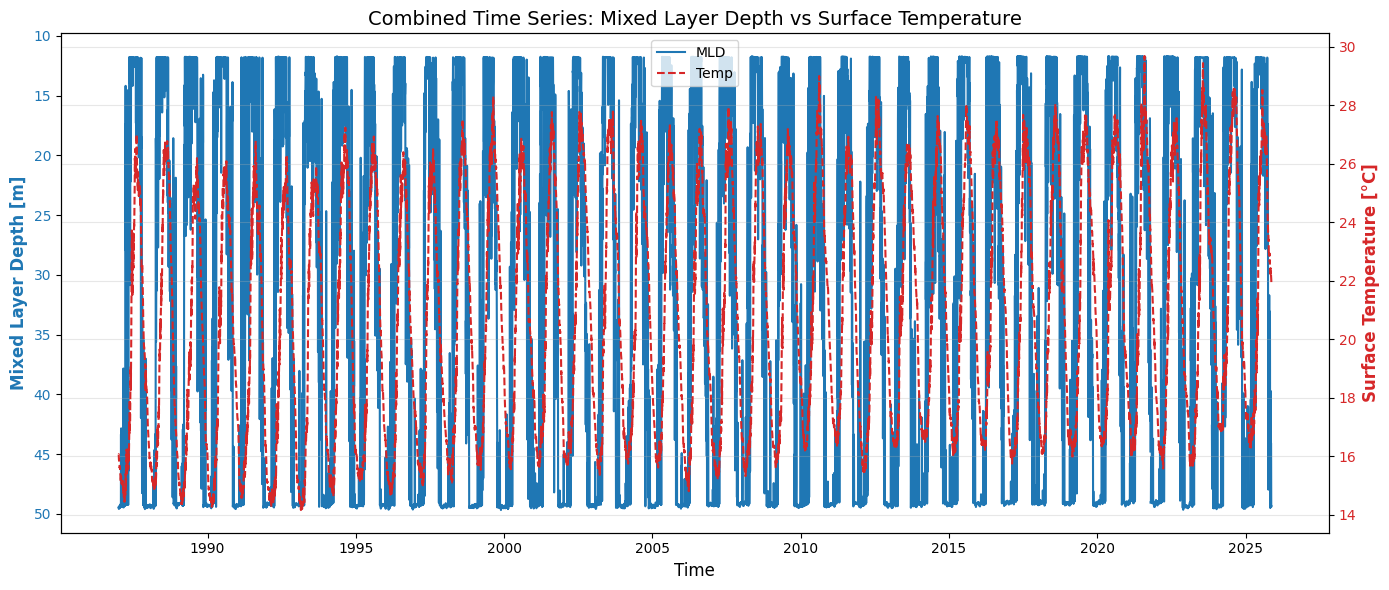

Correlation between MLD and Surface Temperature: -0.61


In [6]:
import xarray as xr
import matplotlib.pyplot as plt

# --- 1. Define Paths ---
# Using raw strings (r"...") to handle Windows backslashes correctly
path_mld = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\MIXED_LAYER_DEPTH\*.nc"
path_temp = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\OCEAN_TEMPERATURE\*.nc"

# --- 2. Load Datasets ---
print("Loading datasets...")
# chunks={"time": -1} loads it lazily initially, .load() brings it into RAM
ds_mld = xr.open_mfdataset(path_mld, combine='by_coords', chunks={"time": -1})
ds_temp = xr.open_mfdataset(path_temp, combine='by_coords', chunks={"time": -1})

# --- 3. Merge into one Dataset ---
# join='inner' keeps only the time steps that exist in BOTH files (intersection)
# This fixes the warning and ensures alignment
ds_combined = xr.merge([ds_mld, ds_temp], join='inner')

# Load actual data into memory to speed up plotting/calculations
ds_combined = ds_combined.load()

print("Datasets merged successfully.")
print(ds_combined)

# --- 4. Prepare Variables ---
# Mixed Layer Depth (1D: time)
mld = ds_combined['mlotst']

# Ocean Temperature (2D: time, depth) -> We select Surface Depth (index 0)
# .isel(depth=0) selects the first depth level (usually surface)
surface_temp = ds_combined['thetao'].isel(depth=0)

# --- 5. Plotting Together (Dual Axis) ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot MLD on Left Axis
color_mld = 'tab:blue'
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontweight='bold', fontsize=12)
ax1.plot(ds_combined.time, mld, color=color_mld, linewidth=1.5, label='MLD')
ax1.tick_params(axis='y', labelcolor=color_mld)

# Invert Y-axis for Depth (so "deeper" is lower on the graph)
ax1.invert_yaxis()

# Create Right Axis for Temperature
ax2 = ax1.twinx()
color_temp = 'tab:red'
ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontweight='bold', fontsize=12)
ax2.plot(ds_combined.time, surface_temp, color=color_temp, linewidth=1.5, linestyle='--', label='Temp')
ax2.tick_params(axis='y', labelcolor=color_temp)

plt.title("Combined Time Series: Mixed Layer Depth vs Surface Temperature", fontsize=14)
plt.grid(True, alpha=0.3)

# Optional: Add a combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.tight_layout()
plt.show()

# --- 6. Correlation ---
# We calculate correlation only using the surface temperature
correlation = xr.corr(mld, surface_temp, dim='time')

# formatting the float result (.2f)
print(f"Correlation between MLD and Surface Temperature: {correlation.values:.2f}")

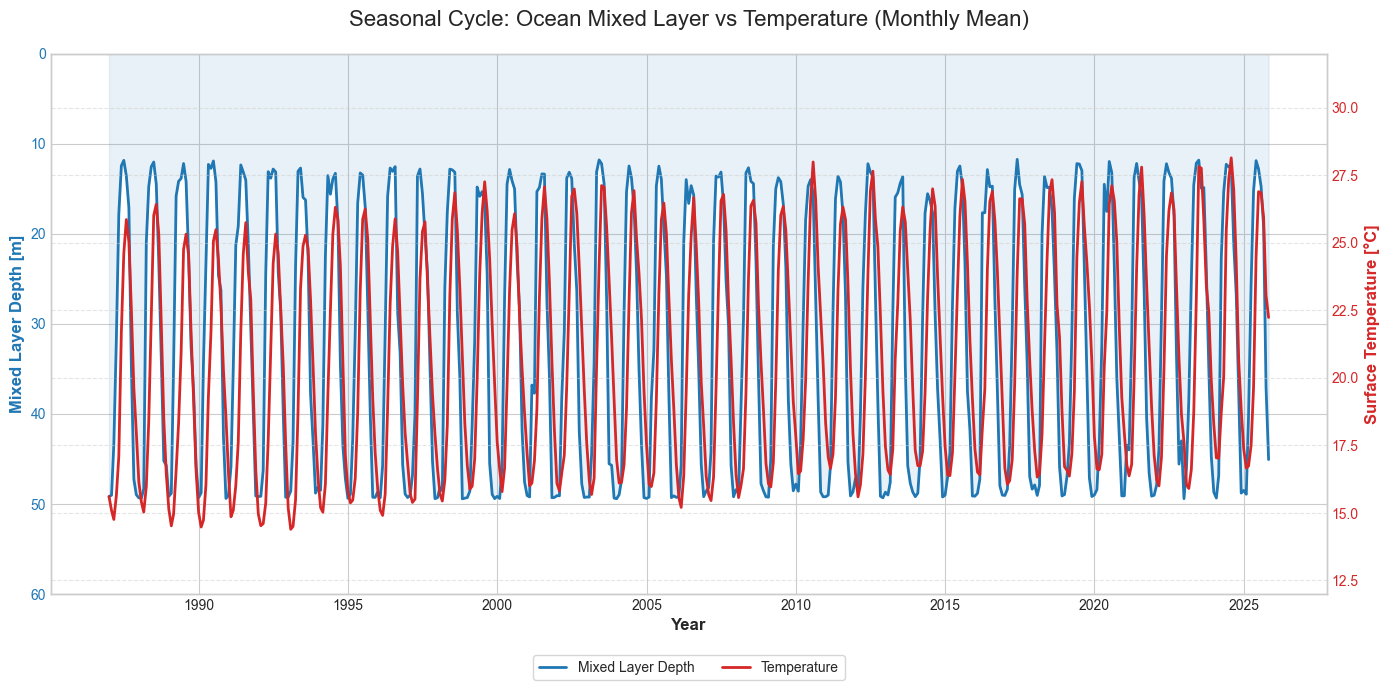

Correlation (Monthly Means): -0.65


In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd # Χρειάζεται για χειρισμό ημερομηνιών αν χρειαστεί

# --- 1. Load & Merge (Όπως πριν) ---
path_mld = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\MIXED_LAYER_DEPTH\*.nc"
path_temp = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\OCEAN_TEMPERATURE\*.nc"

ds_mld = xr.open_mfdataset(path_mld, combine='by_coords', chunks={"time": -1})
ds_temp = xr.open_mfdataset(path_temp, combine='by_coords', chunks={"time": -1})
ds_combined = xr.merge([ds_mld, ds_temp], join='inner').load()

# --- 2. Data Processing (Η ΑΛΛΑΓΗ ΕΙΝΑΙ ΕΔΩ) ---

# Επιλογή επιφάνειας για τη θερμοκρασία
surface_temp = ds_combined['thetao'].isel(depth=0)
mld = ds_combined['mlotst']

# RESAMPLE: Μετατροπή σε Μηνιαίους Μέσους Όρους (Monthly Means)
# '1MS' σημαίνει "1st of Month Start". Παίρνει το μέσο όρο κάθε μήνα.
# Αυτό μειώνει τα δεδομένα από ~14,000 σημεία σε ~450 σημεία -> Πολύ πιο καθαρό.
mld_monthly = mld.resample(time='1MS').mean()
temp_monthly = surface_temp.resample(time='1MS').mean()

# --- 3. Plotting (Βελτιωμένο Στυλ) ---
# Χρήση στυλ για πιο καθαρό background (αν υποστηρίζεται, αλλιώς αγνόησέ το)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot') # Εναλλακτικό στυλ

fig, ax1 = plt.subplots(figsize=(14, 7))

# --- Αριστερός Άξονας: MLD (Μπλε) ---
color_mld = '#1f77b4' # Steel Blue
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontsize=12, fontweight='bold')

# Plot με ελαφρύ γέμισμα (area chart)
ax1.fill_between(mld_monthly.time, mld_monthly, 0, color=color_mld, alpha=0.1)
ax1.plot(mld_monthly.time, mld_monthly, color=color_mld, linewidth=2, label='Mixed Layer Depth')

ax1.tick_params(axis='y', labelcolor=color_mld)
ax1.invert_yaxis() # Το βάθος μεγαλώνει προς τα κάτω
ax1.set_ylim(60, 0) # Ορίζουμε όρια για να "αναπνέει" το γράφημα (π.χ. μέχρι 60m)

# --- Δεξιός Άξονας: Θερμοκρασία (Κόκκινο) ---
ax2 = ax1.twinx()
color_temp = '#d62728' # Brick Red
ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontsize=12, fontweight='bold')

# Plot γραμμής
ax2.plot(temp_monthly.time, temp_monthly, color=color_temp, linewidth=2, linestyle='-', label='Temperature')
ax2.tick_params(axis='y', labelcolor=color_temp)
# Ρυθμίζουμε τα όρια για να μην πέφτει η μία γραμμή πάνω στην άλλη τελείως
# Π.χ. από 10 βαθμούς μέχρι 32
ax2.set_ylim(12, 32)

# --- Τίτλοι και Legend ---
plt.title("Seasonal Cycle: Ocean Mixed Layer vs Temperature (Monthly Mean)", fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)

# Δημιουργία ενός κοινού Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=True)

plt.tight_layout()
plt.show()

# --- Correlation υπολογισμένη στα μηνιαία δεδομένα (πιο ακριβής για εποχικότητα) ---
corr = xr.corr(mld_monthly, temp_monthly, dim='time')
print(f"Correlation (Monthly Means): {corr.values:.2f}")

Loading and merging datasets (All Years)...
Data loaded successfully.
Calculating Climatology (1990-2020 baseline)...
Generating Graph...


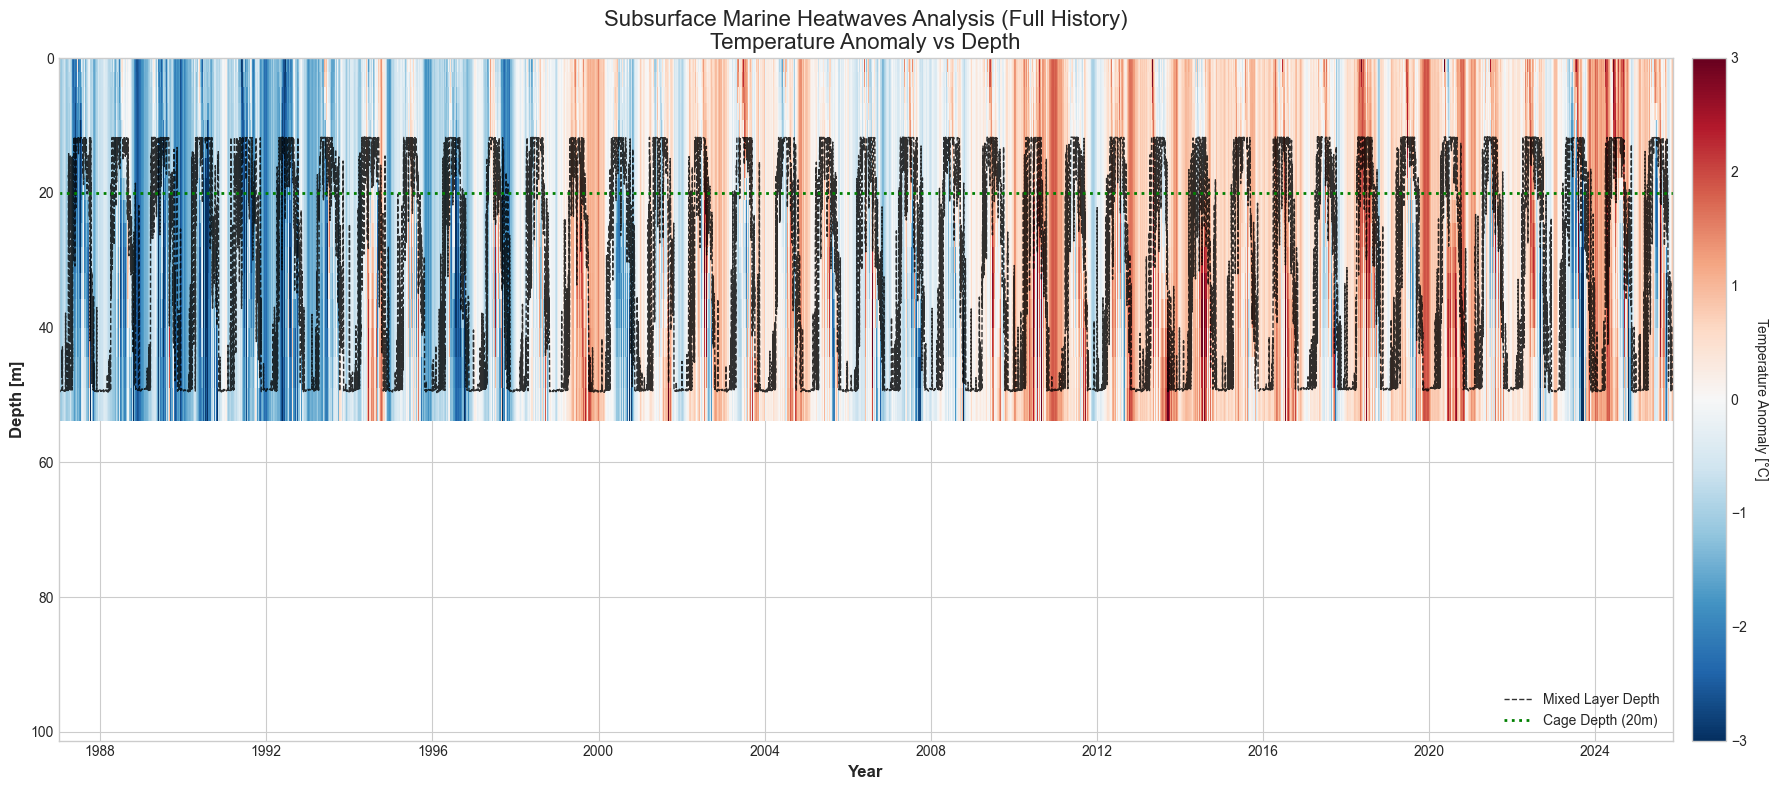


--- IDENTIFIED MHW EVENTS (Top 10 by Intensity) ---
Start Date  Duration [Days]  Max Intensity [°C]  Vertical Extent [m]
2020-05-15                6                4.24            51.379860
2021-06-24                9                3.46             5.464963
2013-04-26               17                3.25            51.379860
2023-07-06               38                3.13            13.318384
2021-07-31                6                3.03            51.379860
2024-06-02               31                2.99            51.379860
2018-05-13               18                2.92            51.379860
2023-12-05              150                2.83            51.379860
2025-06-05               12                2.73             7.920377
2016-04-12               15                2.73            51.379860


In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# Suppress warnings for cleaner output (optional, but good for presentation)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- 1. Load Data ---
# Update these paths to match your local folders exactly
path_mld = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\MIXED_LAYER_DEPTH\*.nc"
path_temp = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\OCEAN_TEMPERATURE\*.nc"

print("Loading and merging datasets (All Years)...")
ds_mld = xr.open_mfdataset(path_mld, combine='by_coords', chunks={"time": -1})
ds_temp = xr.open_mfdataset(path_temp, combine='by_coords', chunks={"time": -1})

# join='inner' ensures we only keep time steps where both Depth and Temp exist
ds = xr.merge([ds_mld, ds_temp], join='inner').load()
print("Data loaded successfully.")

# --- 2. Calculate Climatology & Thresholds (Hobday Definition) ---
print("Calculating Climatology (1990-2020 baseline)...")

# Define baseline period for statistics
baseline = ds.sel(time=slice('1990-01-01', '2020-12-31'))

# Calculate Daily Climatology (Mean) and 90th Percentile Threshold
# grouping by 'dayofyear' handles the seasonality
clim_mean = baseline['thetao'].groupby('time.dayofyear').mean('time')
clim_90 = baseline['thetao'].groupby('time.dayofyear').quantile(0.9, dim='time')

# Calculate Anomaly (Actual Temp - Mean Climatology)
anomaly = ds['thetao'].groupby('time.dayofyear') - clim_mean

# Identify Heatwaves (Boolean mask: True if Temp > 90th Percentile)
is_mhw = ds['thetao'].groupby('time.dayofyear') > clim_90

# --- 3. "Smart Graph": Subsurface Heatwave Visualization (Full Time Series) ---
print("Generating Graph...")
max_plot_depth = 100
subset_anom = anomaly.sel(depth=slice(0, max_plot_depth))
subset_mld = ds['mlotst']

# Make the figure wider to accommodate 30+ years of data
fig, ax = plt.subplots(figsize=(20, 8))

# A. The Heatmap (Time vs Depth)
# Diverging colormap: Red (Hot) / Blue (Cold) / White (Normal)
c = ax.pcolormesh(subset_anom.time, subset_anom.depth, subset_anom.T,
                  cmap='RdBu_r', vmin=-3, vmax=3, shading='auto')

# B. Overlay Mixed Layer Depth (The black dashed line)
ax.plot(subset_mld.time, subset_mld, color='k', linestyle='--', linewidth=1, alpha=0.8, label='Mixed Layer Depth')

# C. Formatting
ax.invert_yaxis() # 0m at top, 100m at bottom
ax.set_ylabel('Depth [m]', fontsize=12, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_title('Subsurface Marine Heatwaves Analysis (Full History)\nTemperature Anomaly vs Depth', fontsize=16)

# Add line for typical aquaculture cage depth
ax.axhline(y=20, color='green', linestyle=':', linewidth=2, label='Cage Depth (20m)')

# Colorbar
cbar = plt.colorbar(c, ax=ax, pad=0.01)
cbar.set_label('Temperature Anomaly [°C]', rotation=270, labelpad=15)

ax.legend(loc='lower right', facecolor='white', framealpha=1)

# Ensure the x-axis covers the full data range
plt.xlim(ds.time.values[0], ds.time.values[-1])

plt.tight_layout()
plt.show()

# --- 4. Characterize Events (Robust Logic) ---
print("\n--- IDENTIFIED MHW EVENTS (Top 10 by Intensity) ---")

# Extract Surface Data to find start/end dates
sst_mhw = is_mhw.isel(depth=0).astype(int)
events = sst_mhw.diff(dim='time')

# Find start (+1) and end (-1) indices
starts = events.where(events == 1, drop=True).time
ends = events.where(events == -1, drop=True).time

# Safe pairing of start/end dates
if len(starts) > 0 and len(ends) > 0:
    # Ensure we don't go out of bounds if an event is ongoing
    min_len = min(len(starts), len(ends))
    event_data = []

    for i in range(min_len):
        t_start = starts[i].values
        t_end = ends[i].values

        # Calculate Duration
        duration = (t_end - t_start).astype('timedelta64[D]').astype(int)

        # Hobday definition: Event must be >= 5 days
        if duration >= 5:
            # Create a slice for this specific event
            temp_slice = anomaly.sel(time=slice(t_start, t_end))

            # --- SAFETY CHECK: Skip if data is missing (NaN) ---
            if temp_slice.size == 0 or temp_slice.isnull().all():
                continue

            # 1. Intensity (Max Anomaly at Surface)
            surf_slice = temp_slice.isel(depth=0)
            # np.nanmax handles NaNs safely
            max_intensity = np.nanmax(surf_slice.values)

            # 2. Vertical Extent (Deepest penetration)
            mean_profile = temp_slice.mean('time')
            # Find all depths where the mean anomaly was positive
            positive_depths = mean_profile.depth.where(mean_profile > 0, drop=True)

            if positive_depths.size > 0:
                max_depth = positive_depths.max().values
            else:
                max_depth = 0.0

            event_data.append({
                "Start Date": str(t_start)[:10],
                "Duration [Days]": duration,
                "Max Intensity [°C]": round(float(max_intensity), 2),
                "Vertical Extent [m]": float(max_depth)
            })

    # Create DataFrame and display
    df_events = pd.DataFrame(event_data)

    if not df_events.empty:
        # Sort by Intensity to show the most severe events first
        df_sorted = df_events.sort_values(by="Max Intensity [°C]", ascending=False)
        print(df_sorted.head(10).to_string(index=False))

        # Optional: Save to CSV
        # df_sorted.to_csv("marine_heatwaves_list.csv", index=False)
        # print("\nFull list saved to marine_heatwaves_list.csv")
    else:
        print("No events > 5 days found.")
else:
    print("Insufficient data to detect discrete events.")

Loading SR1 Temperature Data...


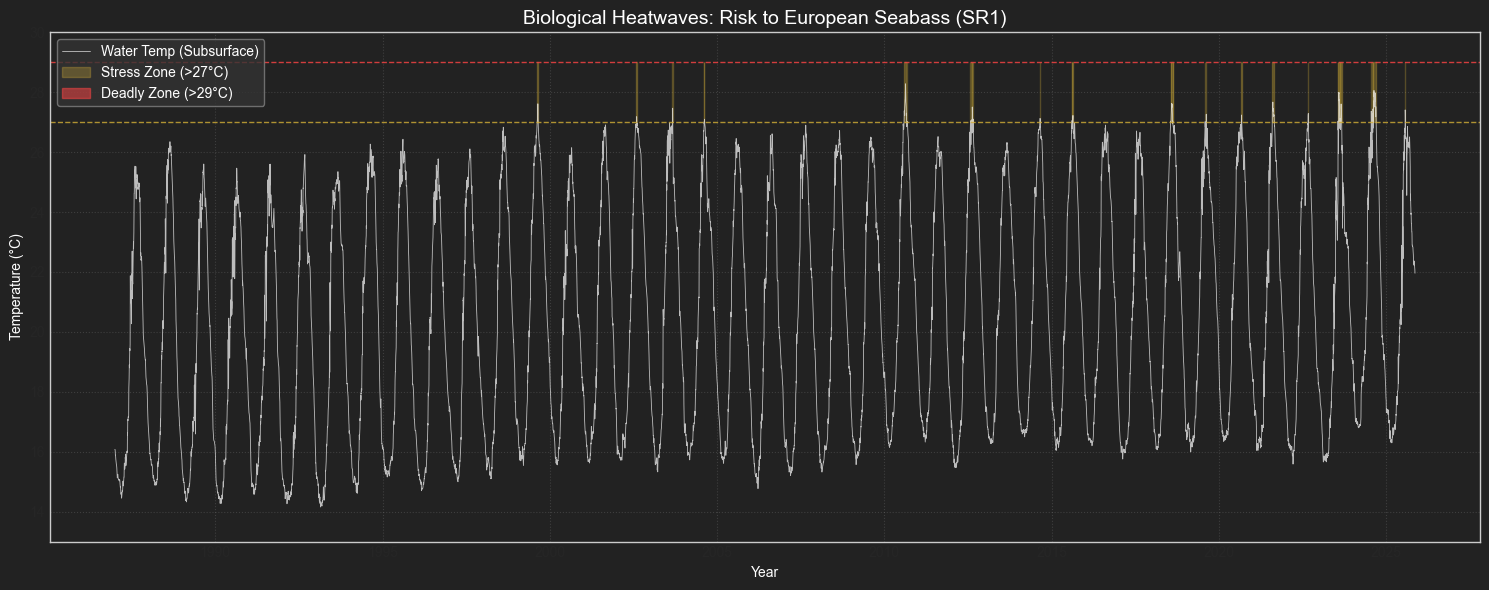


--- Top Heatwave Events (Sorted by Duration) ---
start_date   end_date  duration_days  max_temp  avg_excess
2024-08-14 2024-09-15             33 28.061131    0.644338
2010-08-05 2010-08-31             27 28.281336    0.595752
2021-08-07 2021-08-29             23 27.671587    0.376143
2018-07-26 2018-08-15             21 27.623800    0.359414
2023-08-03 2023-08-14             12 27.995321    0.623631


In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

# --- 1. Load SR1 Data ---
# Update this path to point to your SR1 folder
base_path = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\OCEAN_TEMPERATURE"
path_temp = os.path.join(base_path, "*.nc")

print("Loading SR1 Temperature Data...")
ds = xr.open_mfdataset(path_temp, combine='by_coords', chunks={"time": -1})

# Extract Subsurface Temperature (Depth = 5, approx 5-6m)
# We check depth index 5 usually for subsurface cages, or index 0 for surface.
# Let's assume depth=5 based on standard cage depths, or adjust if needed.
# If you want surface, change to .isel(depth=0)
temp_series = ds['thetao'].isel(depth=5).load()

# Calculate a rolling mean to smooth out daily noise (optional but makes graph cleaner)
# temp_smooth = temp_series.rolling(time=7, center=True).mean()
temp_smooth = temp_series # Using raw data for accuracy

# --- 2. Define Biological Thresholds (European Seabass) ---
stress_temp = 27.0
deadly_temp = 29.0

# --- 3. Create the Graph ---
fig, ax = plt.subplots(figsize=(15, 6))

# Set dark background style if you prefer (like the image)
plt.style.use('dark_background')
fig.patch.set_facecolor('#222222')
ax.set_facecolor('#222222')

# A. Plot the Temperature Line
ax.plot(temp_smooth.time, temp_smooth, color='white', linewidth=0.6, alpha=0.7, label='Water Temp (Subsurface)')

# B. Add the Stress Zone (> 27°C)
# We fill the area between 27 and 29 with yellow/orange
ax.axhline(y=stress_temp, color='#d4af37', linestyle='--', linewidth=1, alpha=0.8) # Gold line
ax.fill_between(temp_smooth.time, stress_temp, deadly_temp,
                where=(temp_smooth >= stress_temp),
                color='#d4af37', alpha=0.3, label='Stress Zone (>27°C)')

# C. Add the Deadly Zone (> 29°C)
# We fill the area above 29 with red
ax.axhline(y=deadly_temp, color='#ff4444', linestyle='--', linewidth=1, alpha=0.8) # Red line
ax.fill_between(temp_smooth.time, deadly_temp, 35, # 35 is just an arbitrary upper limit for drawing
                where=(temp_smooth >= deadly_temp),
                color='#ff4444', alpha=0.5, label='Deadly Zone (>29°C)')

# --- 4. Formatting ---
ax.set_title("Biological Heatwaves: Risk to European Seabass (SR1)", fontsize=14, color='white')
ax.set_ylabel("Temperature (°C)", color='white')
ax.set_xlabel("Year", color='white')
ax.set_ylim(13, 30) # Set Y-axis limits to focus on the relevant range
ax.grid(True, color='gray', linestyle=':', alpha=0.3)

# Customize Legend
legend = ax.legend(loc='upper left', frameon=True, facecolor='#333333', edgecolor='gray')
for text in legend.get_texts():
    text.set_color("white")

plt.tight_layout()
plt.show()

# --- 5. (Optional) Generate the Table shown in your image ---
# Convert to pandas for easy filtering
df = temp_smooth.to_dataframe().reset_index()
df = df[['time', 'thetao']]

# Filter for Heatwave Events (> 27°C)
hw_days = df[df['thetao'] > stress_temp].copy()

if not hw_days.empty:
    # Logic to group consecutive days into "Events"
    hw_days['group'] = (hw_days['time'].diff().dt.days > 1).cumsum()

    events = []
    for _, group in hw_days.groupby('group'):
        start_date = group['time'].min()
        end_date = group['time'].max()
        duration = (end_date - start_date).days + 1
        max_temp = group['thetao'].max()
        avg_excess = (group['thetao'] - stress_temp).mean()

        events.append({
            'start_date': start_date,
            'end_date': end_date,
            'duration_days': duration,
            'max_temp': max_temp,
            'avg_excess': avg_excess
        })

    events_df = pd.DataFrame(events)
    print("\n--- Top Heatwave Events (Sorted by Duration) ---")
    print(events_df.sort_values(by='duration_days', ascending=False).head(5).to_string(index=False))
else:
    print("\nNo biological heatwave events (>27°C) detected in this dataset.")

Loading datasets...
Correlation between Mixed Layer Depth and Surface Temperature: -0.61


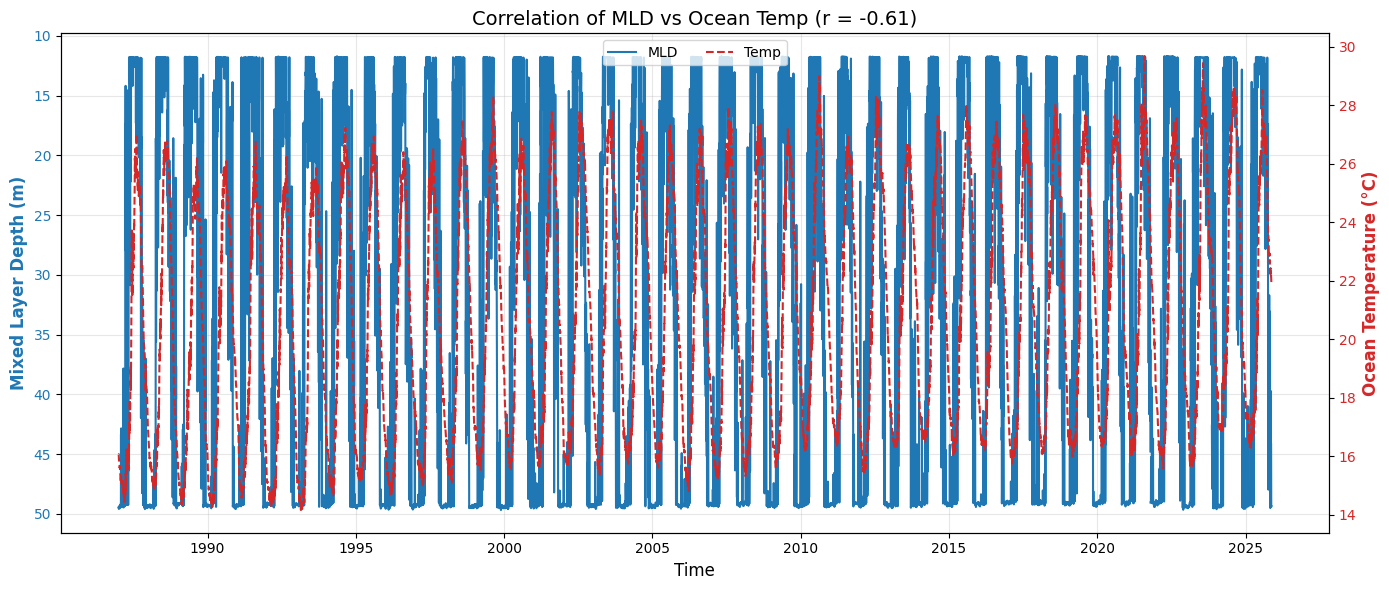

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Define Paths ---
# I am using the paths you provided earlier for both variables
path_mld = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\MIXED_LAYER_DEPTH\*.nc"
path_temp = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\OCEAN_TEMPERATURE\*.nc"

# --- 2. Load Datasets ---
print("Loading datasets...")
# using chunks to load large data lazily if needed, then .load() to bring into RAM for speed
ds_mld = xr.open_mfdataset(path_mld, combine='by_coords', chunks={"time": -1})
ds_temp = xr.open_mfdataset(path_temp, combine='by_coords', chunks={"time": -1})

# --- 3. Extract Variables ---
# MLD variable name is usually 'mlotst'
mld = ds_mld['mlotst']

# Temperature variable name is usually 'thetao' (Potential Temperature)
# Note: Temperature often has a 'depth' or 'lev' dimension.
# We usually want the SURFACE temperature for this correlation, so we select depth=0.
# If your data is already just a time series (no depth), .isel(depth=0) might fail,
# in which case you can remove the .isel part.
try:
    temp = ds_temp['thetao'].isel(depth=0) # Select surface layer
except ValueError:
    temp = ds_temp['thetao'] # Data might already be 1D

# --- 4. Merge and Align ---
# This ensures both time series cover the exact same dates
ds_combined = xr.merge([mld.rename('MLD'), temp.rename('Temperature')], join='inner')

# --- 5. Calculate Correlation ---
# Pearson correlation coefficient
correlation = xr.corr(ds_combined['MLD'], ds_combined['Temperature'], dim='time')
print(f"Correlation between Mixed Layer Depth and Surface Temperature: {correlation.values:.2f}")

# --- 6. Plotting Time Series (Dual Axis) ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot MLD (Left Axis)
color_mld = 'tab:blue'
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Mixed Layer Depth (m)', color=color_mld, fontsize=12, fontweight='bold')
ax1.plot(ds_combined.time, ds_combined['MLD'], color=color_mld, linewidth=1.5, label='MLD')
ax1.tick_params(axis='y', labelcolor=color_mld)
ax1.invert_yaxis() # Deeper MLD usually plotted downwards

# Plot Temperature (Right Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color_temp = 'tab:red'
ax2.set_ylabel('Ocean Temperature (°C)', color=color_temp, fontsize=12, fontweight='bold')
ax2.plot(ds_combined.time, ds_combined['Temperature'], color=color_temp, linestyle='--', linewidth=1.5, label='Temp')
ax2.tick_params(axis='y', labelcolor=color_temp)

# Title and Grid
plt.title(f"Correlation of MLD vs Ocean Temp (r = {correlation.values:.2f})", fontsize=14)
ax1.grid(True, alpha=0.3)

# Combined Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', ncol=2)

plt.tight_layout()
plt.show()

--- Loading Ocean Temperature ---
Ocean Data Time Range: 1987-01 to 2025-11

--- Loading Wind Data ---
Wind Data Time Range:  2015-01 to 2025-10

--- Merging Datasets ---
Merged Data Points: 122


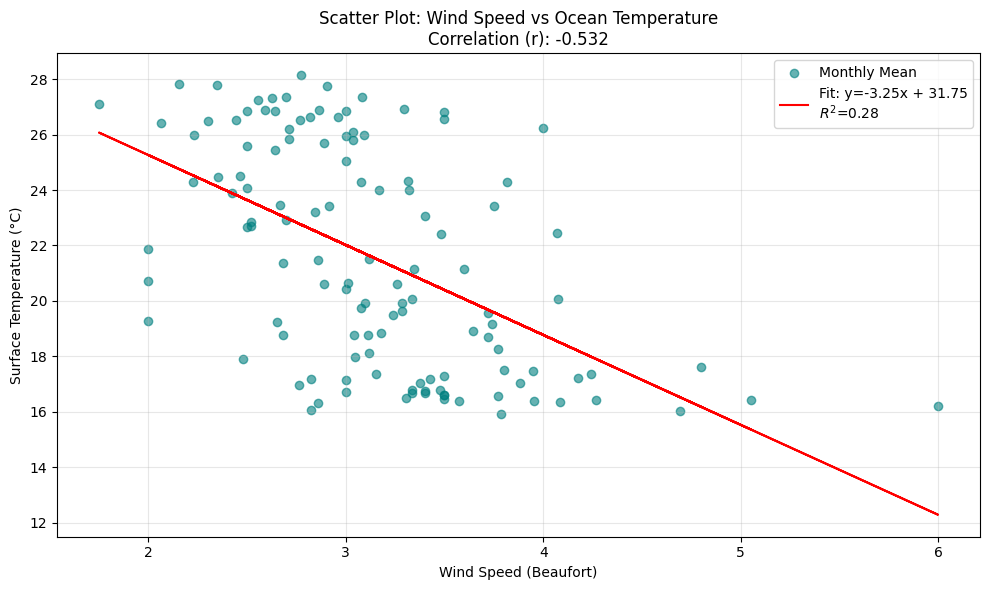

Correlation Coefficient: -0.532


In [13]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import numpy as np
from scipy import stats

# --- 1. Define Paths ---
# Update these to where your actual matching data is located
path_temp = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\OCEAN_TEMPERATURE\*.nc"
path_wind = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\Wind_Aquaculture_Data_SR1.xls"

# --- 2. Load Ocean Temperature ---
print("--- Loading Ocean Temperature ---")
try:
    # parallel=True can help speed up loading multiple files
    ds_temp = xr.open_mfdataset(path_temp, combine='by_coords', chunks={"time": -1}, parallel=False)

    # Select Surface Temperature robustly
    if 'depth' in ds_temp.dims:
        ocean_temp = ds_temp['thetao'].isel(depth=0)
    elif 'lev' in ds_temp.dims:
        ocean_temp = ds_temp['thetao'].isel(lev=0)
    else:
        ocean_temp = ds_temp['thetao']

    # Resample to Monthly Start
    ocean_monthly = ocean_temp.resample(time='1MS').mean()

    print(f"Ocean Data Time Range: {ocean_monthly.time.min().dt.strftime('%Y-%m').values} to {ocean_monthly.time.max().dt.strftime('%Y-%m').values}")

except Exception as e:
    print(f"Error loading NetCDF: {e}")
    raise

# --- 3. Load Wind Data ---
print("\n--- Loading Wind Data ---")
try:
    # Try reading as CSV first (since the content is comma-separated)
    df_wind = pd.read_csv(path_wind)
except:
    try:
        df_wind = pd.read_excel(path_wind)
    except Exception as e:
        print(f"Could not read wind file: {e}")
        raise

# Clean column names
df_wind.columns = [c.strip().lower() for c in df_wind.columns]

# --- 4. Robust Date Conversion ---
def parse_smart_date(x):
    try:
        # Check if it is an Excel Serial Number (e.g., 42005)
        # 42005 = Jan 1, 2015.
        val = float(x)
        if 30000 < val < 60000:
            return datetime.datetime(1899, 12, 30) + datetime.timedelta(days=val)
    except:
        pass

    # Fallback to standard string parsing
    return pd.to_datetime(x, errors='coerce')

df_wind['Date'] = df_wind['date'].apply(parse_smart_date)

# Drop invalid dates and sort
df_wind = df_wind.dropna(subset=['Date'])
df_wind = df_wind.set_index('Date').sort_index()

print(f"Wind Data Time Range:  {df_wind.index.min().strftime('%Y-%m')} to {df_wind.index.max().strftime('%Y-%m')}")

# --- 5. Prepare for Merge (THE FIX) ---
# Resample to Monthly Mean
df_wind_monthly = df_wind.resample('MS')['beaufort'].mean().to_frame()

# *** CRITICAL FIX: Rename the index to 'time' to match xarray dimensions ***
df_wind_monthly.index.name = 'time'

# Convert to xarray
wind_da = xr.DataArray(
    df_wind_monthly['beaufort'],
    dims='time',
    coords={'time': df_wind_monthly.index},
    name='Wind'
)

# --- 6. Merge and Correlate ---
print("\n--- Merging Datasets ---")
# 'inner' join keeps only months present in BOTH datasets
ds_combined = xr.merge([ocean_monthly.rename('Temperature'), wind_da], join='inner')

# Drop NaNs just in case
ds_combined = ds_combined.dropna(dim='time')

print(f"Merged Data Points: {ds_combined.sizes['time']}")

if ds_combined.sizes['time'] < 2:
    print("\n!!! ERROR: No overlapping data found. !!!")
    print("Please check that your Ocean Temperature files cover the years 2015-2025.")
else:
    # Calculate Correlation
    r_val = xr.corr(ds_combined['Temperature'], ds_combined['Wind'], dim='time').values

    # Calculate Linear Regression for the line
    x = ds_combined['Wind'].values
    y = ds_combined['Temperature'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.6, color='teal', label='Monthly Mean')
    plt.plot(x, line, 'r', label=f'Fit: y={slope:.2f}x + {intercept:.2f}\n$R^2$={r_value**2:.2f}')

    plt.title(f"Scatter Plot: Wind Speed vs Ocean Temperature\nCorrelation (r): {r_val:.3f}")
    plt.xlabel("Wind Speed (Beaufort)")
    plt.ylabel("Surface Temperature (°C)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Correlation Coefficient: {r_val:.3f}")

--- Loading Atmospheric Data ---
Atmos Data Range: 1985-01-01 00:00:00 to 2023-12-01 00:00:00

--- Loading Ocean Data ---
Ocean Data Range: 1987-01 to 2025-11

--- Merging Data ---
Overlapping Months: 444

--- Correlation Analysis (Pearson r) ---
Ocean Temp vs 2m air Temperature: r = 0.922
Ocean Temp vs Windspeed: r = -0.469
Ocean Temp vs Shortwave Radiation: r = 0.490


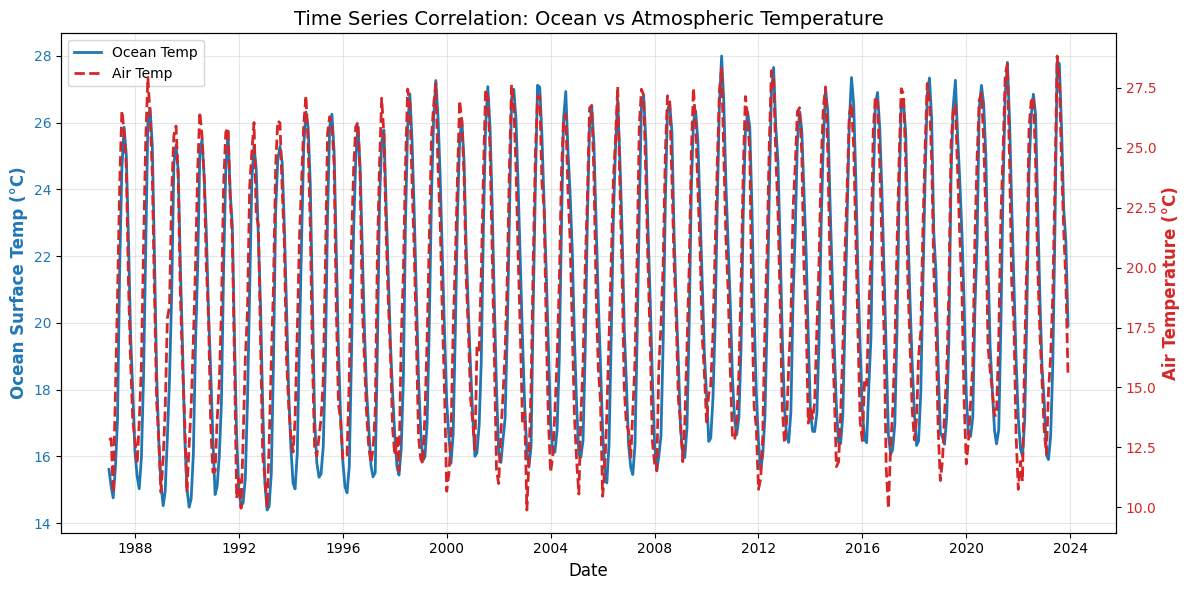

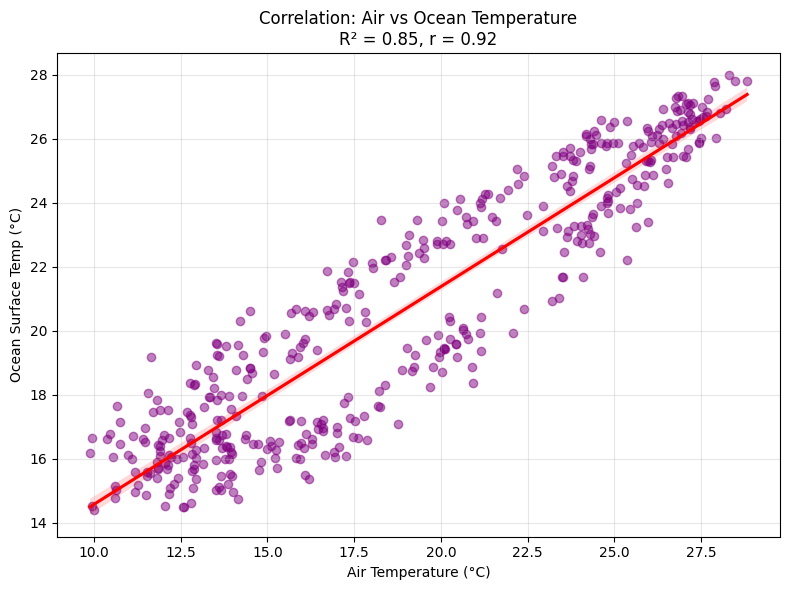

In [17]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- 1. Define Paths ---
path_ocean = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\OCEAN_TEMPERATURE\*.nc"
path_atmos = r"C:\Users\panos\PycharmProjects\PythonProject\SR1-20251125T132706Z-1-001\SR1\ATMOSPHERIC_DATA_SR1_1985_2023.csv"

# --- 2. Load Atmospheric Data (1985-2023) ---
print("--- Loading Atmospheric Data ---")
df_atmos = pd.read_csv(path_atmos)

# Parse Dates (Format: 01-01-85 3:00 -> DD-MM-YY HH:MM)
df_atmos['time'] = pd.to_datetime(df_atmos['time'], format='%d-%m-%y %H:%M')

# Clean Column Names (strip whitespace)
df_atmos.columns = [c.strip() for c in df_atmos.columns]

# FIX: Select only numeric columns before resampling to avoid the "SR1" string error
cols_to_keep = ['Shortwave Radiation', '2m air Temperature', 'Windspeed']
df_atmos = df_atmos.set_index('time')[cols_to_keep]

# Resample to Monthly Means
df_atmos = df_atmos.resample('1MS').mean()
print(f"Atmos Data Range: {df_atmos.index.min()} to {df_atmos.index.max()}")

# Convert to xarray for merging
ds_atmos = xr.Dataset.from_dataframe(df_atmos)

# --- 3. Load Ocean Data (1987-1995) ---
print("\n--- Loading Ocean Data ---")
# parallel=False is safer for Windows
ds_ocean = xr.open_mfdataset(path_ocean, combine='by_coords', chunks={"time": -1}, parallel=False)

# Select Surface Temperature
if 'depth' in ds_ocean.dims:
    ocean_temp = ds_ocean['thetao'].isel(depth=0)
elif 'lev' in ds_ocean.dims:
    ocean_temp = ds_ocean['thetao'].isel(lev=0)
else:
    ocean_temp = ds_ocean['thetao']

# Handle Spatial Dimensions (if 2D Lat/Lon exists, average them)
if 'lat' in ocean_temp.dims and 'lon' in ocean_temp.dims:
    ocean_temp = ocean_temp.mean(dim=['lat', 'lon'])

# Resample to Monthly Means
ocean_monthly = ocean_temp.resample(time='1MS').mean()
print(f"Ocean Data Range: {ocean_monthly.time.min().dt.strftime('%Y-%m').values} to {ocean_monthly.time.max().dt.strftime('%Y-%m').values}")

# --- 4. Merge Datasets ---
print("\n--- Merging Data ---")
# Merge Ocean Temp with Atmospheric Variables
ds_combined = xr.merge([ocean_monthly.rename('Ocean_Temp'), ds_atmos], join='inner')
ds_combined = ds_combined.dropna(dim='time')

print(f"Overlapping Months: {ds_combined.sizes['time']}")

if ds_combined.sizes['time'] < 10:
    print("Warning: Very few overlapping data points found.")
else:
    # --- 5. Calculate Correlations ---
    print("\n--- Correlation Analysis (Pearson r) ---")
    vars_to_test = ['2m air Temperature', 'Windspeed', 'Shortwave Radiation']

    for var in vars_to_test:
        if var in ds_combined:
            r = xr.corr(ds_combined['Ocean_Temp'], ds_combined[var], dim='time').values
            print(f"Ocean Temp vs {var}: r = {r:.3f}")

    # --- 6. Plotting (Focus on Air Temp vs Ocean Temp) ---
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Ocean Temp (Left Axis)
    color1 = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Ocean Surface Temp (°C)', color=color1, fontsize=12, fontweight='bold')
    ax1.plot(ds_combined.time, ds_combined['Ocean_Temp'], color=color1, linewidth=2, label='Ocean Temp')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)

    # Plot Air Temp (Right Axis)
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Air Temperature (°C)', color=color2, fontsize=12, fontweight='bold')
    ax2.plot(ds_combined.time, ds_combined['2m air Temperature'], color=color2, linestyle='--', linewidth=2, label='Air Temp')
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title("Time Series Correlation: Ocean vs Atmospheric Temperature", fontsize=14)

    # Combined Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()

    # --- 7. Scatter Plot (Regression) ---
    x = ds_combined['2m air Temperature'].values
    y = ds_combined['Ocean_Temp'].values

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    plt.figure(figsize=(8, 6))
    sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5, 'color':'purple'}, line_kws={'color':'red'})
    plt.xlabel("Air Temperature (°C)")
    plt.ylabel("Ocean Surface Temp (°C)")
    plt.title(f"Correlation: Air vs Ocean Temperature\nR² = {r_value**2:.2f}, r = {r_value:.2f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()